In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [ ]:
# --- 1. 配置参数 ---
# 数据生成参数
N_SAMPLES = 1000  # 样本数量
N_FEATURES = 5  # 特征数量 (为了方便可视化决策边界，这里设为2)
N_CLASSES = 3  # 类别数量
RANDOM_STATE = 42
DATASET_TYPE = 'blobs' # 'blobs', 'moons', 'circles' # 数据集类型

# 模型参数
INPUT_SIZE = N_FEATURES # 输入特征数量
HIDDEN_LAYERS = [64, 32, 16]  # 每层隐藏层的节点数，列表长度决定隐藏层数量
OUTPUT_SIZE = N_CLASSES # 输出类别数量

# 训练参数
LEARNING_RATE = 0.01
BATCH_SIZE = 32
NUM_EPOCHS = 100

# 可用的激活函数
ACTIVATION_FUNCTIONS = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU': nn.LeakyReLU(), # 可以添加更多
}

# 设备
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [87]:
# --- 2. 数据生成 ---
def generate_data(n_samples=N_SAMPLES, n_features=N_FEATURES, n_classes=N_CLASSES, random_state=RANDOM_STATE, dataset_type=DATASET_TYPE):
    """生成模拟分类数据集"""
    print(f"Generating {dataset_type} data...")
    if dataset_type == 'blobs':
        X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes, cluster_std=1.0, random_state=random_state)
    elif dataset_type == 'moons':
         # make_moons only supports 2 classes and 2 features
        if n_classes != 2 or n_features != 2:
             print("Warning: make_moons only supports n_classes=2 and n_features=2. Adjusting parameters.")
             n_classes = 2
             n_features = 2
        X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=random_state)
    elif dataset_type == 'circles':
         # make_circles only supports 2 classes and 2 features
        if n_classes != 2 or n_features != 2:
             print("Warning: make_circles only supports n_classes=2 and n_features=2. Adjusting parameters.")
             n_classes = 2
             n_features = 2
        X, y = make_circles(n_samples=n_samples, noise=0.05, factor=0.5, random_state=random_state)
    else:
        raise ValueError(f"Unknown dataset type: {dataset_type}")

    # 数据标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 分割训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=random_state, stratify=y if n_classes > 1 else None)

    # 转换为PyTorch Tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long) # CrossEntropyLoss expects Long
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # 创建 DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 返回原始未缩放的测试数据用于决策边界可视化
    _, X_test_orig, _, _ = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y if n_classes > 1 else None)


    return train_loader, test_loader, X_test_tensor, y_test_tensor, scaler, X_test_orig, n_classes # Return actual n_classes in case of moon/circles adjustment


In [88]:
# --- 3. 模型定义 ---
class CustomNet(nn.Module): # 自定义神经网络模型
    def __init__(self, input_size, hidden_layers, output_size, activation_fn):
        """
        自定义神经网络模型

        Args:
            input_size (int): 输入特征维度
            hidden_layers (list): 包含每层隐藏层节点数的列表
            output_size (int): 输出类别数量
            activation_fn (nn.Module): 激活函数实例 (如 nn.ReLU(), nn.Sigmoid())
        """
        super(CustomNet, self).__init__()

        layers = []
        current_size = input_size
        
        for hidden_size in hidden_layers:
            if current_size == input_size:
                layers.append(nn.BatchNorm1d(current_size)) # 第一层添加 BatchNorm
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(activation_fn) # 添加激活函数
            current_size = hidden_size

        layers.append(nn.Dropout(p=0.1)) # 添加 Dropout 层以防止过拟合
        # 输出层
        layers.append(nn.Linear(current_size, output_size))
    
        # 使用 Sequential 组合所有层
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """前向传播"""
        return self.model(x)

In [89]:
# --- 4. 训练模型 ---
def train_model(model, train_loader, criterion, optimizer, num_epochs=NUM_EPOCHS, device=DEVICE):
    """训练神经网络模型"""
    model.train() # 设置模型为训练模式
    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 反向传播和优化
            optimizer.zero_grad() # 清零梯度
            loss.backward()       # 计算梯度
            optimizer.step()      # 更新权重

            running_loss += loss.item() * inputs.size(0) # 累积损失

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    print("Training finished.")
    return train_losses


In [90]:
# --- 5. 评估模型 ---
def evaluate_model(model, test_loader, criterion, device=DEVICE):
    """评估神经网络模型"""
    model.eval() # 设置模型为评估模式
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []
    test_loss = 0.0

    with torch.no_grad(): # 禁用梯度计算
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels) # 计算测试损失
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1) # 获取预测类别 (dim=1 表示在第1维找最大值)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    test_loss /= len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')

    # 计算其他分类指标
    report = classification_report(all_labels, all_predictions, output_dict=True)
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return accuracy, report, conf_matrix, test_loss, all_predictions, all_labels


In [91]:
# --- 6. 可视化 ---
def plot_loss(train_losses, title="Training Loss over Epochs"):
    """绘制训练损失曲线"""
    plt.figure()
    plt.plot(train_losses)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

In [92]:
def plot_decision_boundary(model, X, y, scaler, activation_name, title="Decision Boundary"):
    """
    绘制模型的决策边界 (仅适用于2D输入特征)

    Args:
        model (nn.Module): 训练好的模型
        X (np.ndarray): 原始 (未缩放) 的测试数据特征
        y (np.ndarray): 原始的测试数据标签
        scaler (StandardScaler): 用于缩放数据的 StandardScaler 实例
        activation_name (str): 激活函数名称 (用于标题)
        title (str): 图标题
    """
    if X.shape[1] != 2:
        print("Cannot plot decision boundary for data with more than 2 features.")
        return

    # 设置模型为评估模式并移动到设备
    model.eval()
    model.to(DEVICE)

    # 定义网格范围
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = .02  # 网格步长
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # 在网格点上进行预测
    # 需要将网格点缩放到和训练数据一样的尺度
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_scaled = scaler.transform(grid_points) # 使用之前fit好的scaler
    grid_points_tensor = torch.tensor(grid_points_scaled, dtype=torch.float32).to(DEVICE)

    with torch.no_grad():
        Z = model(grid_points_tensor)
        _, Z = torch.max(Z.data, 1) # 获取预测类别
        Z = Z.cpu().numpy().reshape(xx.shape)

    # 绘制决策边界
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu) # 绘制等高线填充

    # 绘制数据点
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='k', marker='o')
    plt.title(f'{title} ({activation_name} Activation)')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Class')
    plt.show()


In [93]:
def plot_confusion_matrix(conf_matrix, classes, activation_name, title="Confusion Matrix"):
    """绘制混淆矩阵"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{title} ({activation_name} Activation)')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [94]:
# --- 7. 模型保存和ONNX导出 ---
def save_model_pytorch(model, path):
    """保存PyTorch模型状态字典"""
    torch.save(model.state_dict(), path)
    print(f"PyTorch model saved to {path}")


In [95]:
def export_model_onnx(model, dummy_input_shape, path, device=DEVICE):
    """导出模型到ONNX格式"""
    model.to('cpu') # ONNX export usually happens on CPU
    model.eval() # Ensure model is in eval mode for export

    # 创建一个与模型输入形状匹配的虚拟输入 (批量大小通常设为1)
    dummy_input = torch.randn(dummy_input_shape).to('cpu')

    try:
        torch.onnx.export(model,                     # 要导出的模型
                          dummy_input,               # 模型输入示例 (用于跟踪计算图)
                          path,                      # 保存 ONNX 模型的路径
                          export_params=True,        # 导出训练参数
                          opset_version=11,          # ONNX opset 版本 (根据需要调整)
                          do_constant_folding=True,  # 是否执行常量折叠优化
                          input_names=['input'],     # 输入节点的名称
                          output_names=['output'],   # 输出节点的名称
                          dynamic_axes={'input' : {0 : 'batch_size'},    # 如果希望支持动态批量大小
                                        'output' : {0 : 'batch_size'}})

        print(f"Model successfully exported to ONNX format at {path}")
    except Exception as e:
        print(f"Error exporting model to ONNX: {e}")

    model.to(device) # Move model back to original device if needed


Generating blobs data...

--- Running experiment with ReLU Activation ---
Epoch [10/100], Loss: 0.0108
Epoch [20/100], Loss: 0.0012
Epoch [30/100], Loss: 0.0008
Epoch [40/100], Loss: 0.0037
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0127
Epoch [70/100], Loss: 0.0013
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0013
Training finished.


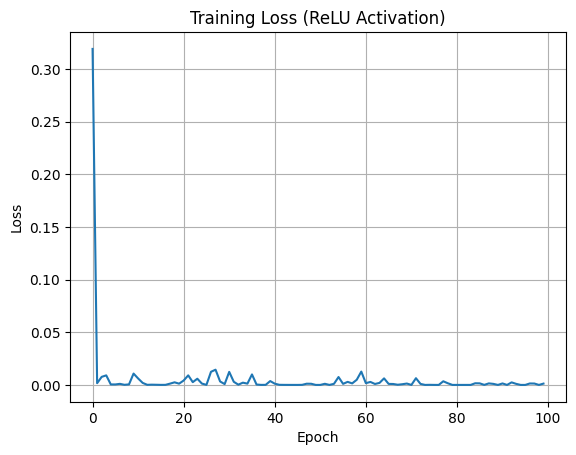


Evaluating model with ReLU Activation...
Test Loss: 0.0000
Test Accuracy: 1.0000

Classification Report (ReLU Activation):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       1.00      1.00      1.00        67
           2       1.00      1.00      1.00        66

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



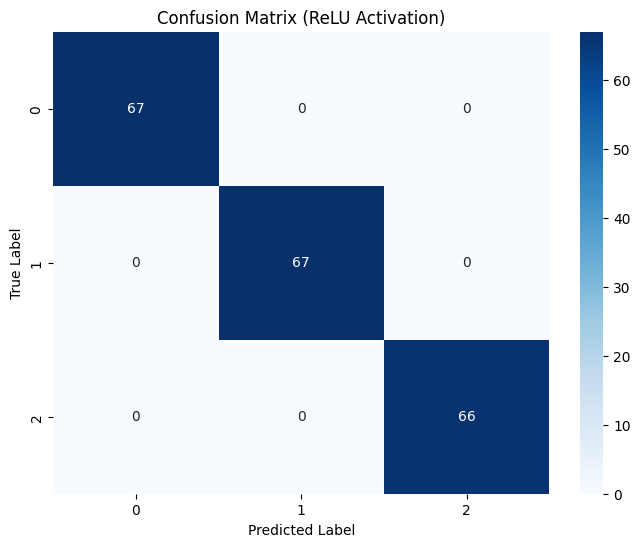

PyTorch model saved to models/model_relu.pth
Model successfully exported to ONNX format at models/model_relu.onnx

--- Running experiment with Sigmoid Activation ---
Epoch [10/100], Loss: 0.0091
Epoch [20/100], Loss: 0.0030
Epoch [30/100], Loss: 0.0025
Epoch [40/100], Loss: 0.0013
Epoch [50/100], Loss: 0.0011
Epoch [60/100], Loss: 0.0007
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0005
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0004
Training finished.


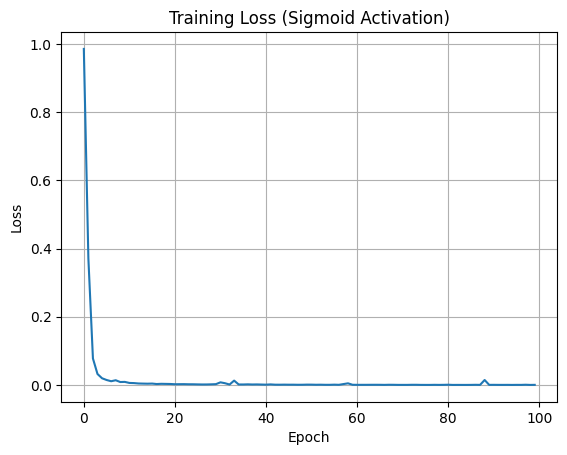


Evaluating model with Sigmoid Activation...
Test Loss: 0.0000
Test Accuracy: 1.0000

Classification Report (Sigmoid Activation):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       1.00      1.00      1.00        67
           2       1.00      1.00      1.00        66

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



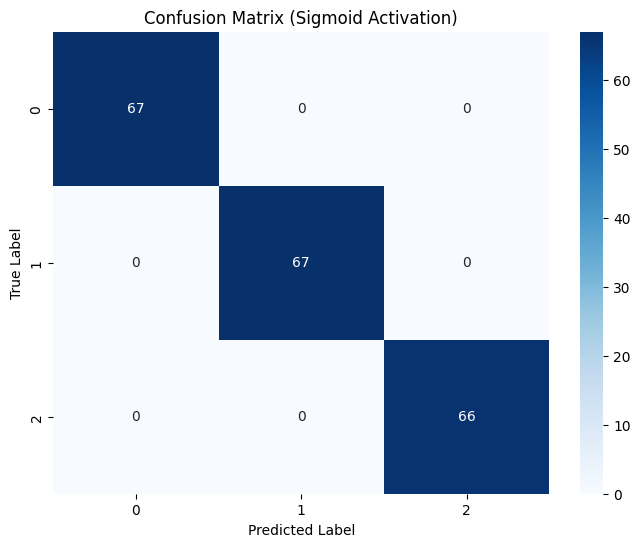

PyTorch model saved to models/model_sigmoid.pth
Model successfully exported to ONNX format at models/model_sigmoid.onnx

--- Running experiment with Tanh Activation ---
Epoch [10/100], Loss: 0.0010
Epoch [20/100], Loss: 0.0005
Epoch [30/100], Loss: 0.0003
Epoch [40/100], Loss: 0.0001
Epoch [50/100], Loss: 0.0001
Epoch [60/100], Loss: 0.0001
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0001
Training finished.


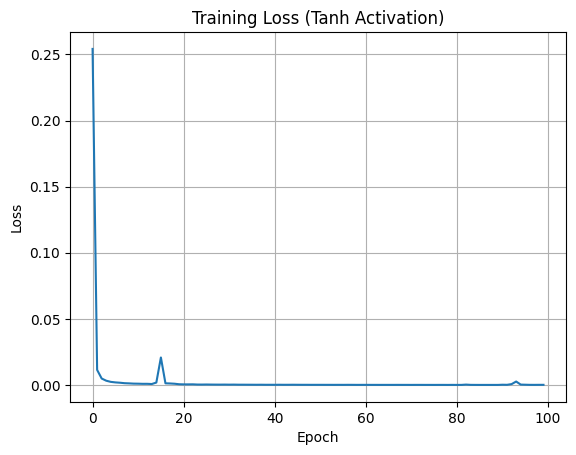


Evaluating model with Tanh Activation...
Test Loss: 0.0000
Test Accuracy: 1.0000

Classification Report (Tanh Activation):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       1.00      1.00      1.00        67
           2       1.00      1.00      1.00        66

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



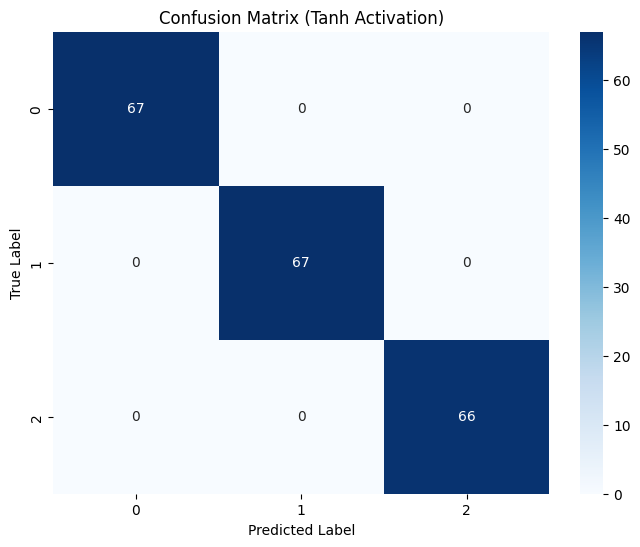

PyTorch model saved to models/model_tanh.pth
Model successfully exported to ONNX format at models/model_tanh.onnx

--- Results Summary ---

Activation: ReLU
  Test Accuracy: 1.0000
  Test Loss: 0.0000

Activation: Sigmoid
  Test Accuracy: 1.0000
  Test Loss: 0.0000

Activation: Tanh
  Test Accuracy: 1.0000
  Test Loss: 0.0000

All experiments finished.


In [96]:
# --- 8. 主执行流程 ---
if __name__ == "__main__":
    # 创建保存模型和结果的目录
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)

    # 生成数据
    train_loader, test_loader, X_test_tensor, y_test_tensor, scaler, X_test_orig, actual_n_classes = generate_data(
        n_samples=N_SAMPLES,
        n_features=N_FEATURES,
        n_classes=N_CLASSES,
        random_state=RANDOM_STATE,
        dataset_type=DATASET_TYPE
    )
    # 调整输出层大小以匹配实际类别数 (针对 moons/circles)
    OUTPUT_SIZE = actual_n_classes


    results_summary = {} # 存储不同激活函数的评估结果

    # 遍历不同的激活函数进行实验
    for activation_name, activation_fn_instance in ACTIVATION_FUNCTIONS.items():
        print(f"\n--- Running experiment with {activation_name} Activation ---")

        # 初始化模型、损失函数和优化器
        # 注意: 每次实验都重新初始化模型，以确保权重是随机开始的
        model = CustomNet(INPUT_SIZE, HIDDEN_LAYERS, OUTPUT_SIZE, activation_fn_instance).to(DEVICE)
        criterion = nn.CrossEntropyLoss() # 适用于多分类，内部包含 LogSoftmax 和 NLLLoss
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # 训练模型
        train_losses = train_model(model, train_loader, criterion, optimizer, NUM_EPOCHS, DEVICE)
        plot_loss(train_losses, title=f"Training Loss ({activation_name} Activation)")

        # 评估模型
        print(f"\nEvaluating model with {activation_name} Activation...")
        accuracy, report, conf_matrix, test_loss, all_predictions, all_labels = evaluate_model(model, test_loader, criterion, DEVICE)

        # 打印评估报告
        print(f"\nClassification Report ({activation_name} Activation):\n")
        print(classification_report(all_labels, all_predictions))

        # 存储结果
        results_summary[activation_name] = {
            'accuracy': accuracy,
            'test_loss': test_loss,
            'report': report,
            'conf_matrix': conf_matrix.tolist() # 将numpy array转换为list以便打印或保存
        }

        # 可视化结果
        # 获取实际的类别标签用于混淆矩阵
        unique_classes = sorted(list(set(all_labels) | set(all_predictions))) # 确保包含所有真实和预测的类别
        plot_confusion_matrix(conf_matrix, classes=unique_classes, activation_name=activation_name)

        if N_FEATURES == 2: # 只在2D数据时绘制决策边界
             plot_decision_boundary(model, X_test_orig, y_test_tensor.cpu().numpy(), scaler, activation_name)


        # 保存模型
        model_save_path = f"models/model_{activation_name.lower()}.pth"
        save_model_pytorch(model, model_save_path)

        # 导出ONNX模型
        onnx_save_path = f"models/model_{activation_name.lower()}.onnx"
        # ONNX输入形状需要 (Batch_size, Input_features)
        dummy_input_shape = (1, INPUT_SIZE)
        export_model_onnx(model, dummy_input_shape, onnx_save_path, DEVICE)

    # 打印总结报告
    print("\n--- Results Summary ---")
    for activation, metrics in results_summary.items():
        print(f"\nActivation: {activation}")
        print(f"  Test Accuracy: {metrics['accuracy']:.4f}")
        print(f"  Test Loss: {metrics['test_loss']:.4f}")
        # 可以选择打印更详细的报告或只打印关键指标

    print("\nAll experiments finished.")